In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.cm import get_cmap


In [4]:
df = pd.read_csv("../data/benin-malanville.csv", parse_dates=["Timestamp"])
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  int64         
 15  

In [5]:
print("The description of the numeric columns:")
print(df.describe())
print("---------------------------------------")
print("The description of the categorical columns:")
if not df.select_dtypes(include='object').empty:
    print(df.describe(include=["object"]))
else:
    print("No object (categorical/string) columns found.")
print("----------------------------------------")
print("The description of all columns")
print(df.describe(include='all'))
print("----------------------------------------")
print("An overview of the dataset: the first 5 rows")
print(df.head())
print("-----------------------------------------")
print("An overview of the dataset: the last 5 rows")
print(df.tail())
print("-----------------------------------------")
print("An overview of the dataset: a random sample of 5 rows")
print(df.sample(5))
print("-----------------------------------------")
print("An overview of the dataset: the shape of the dataset")
print(df.info())
print("------------------------------------------")
print("Check for missing values:")
print(df.isna().sum())

The description of the numeric columns:
                           Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-02-07 12:00:30.000000512     240.559452     167.187516   
min              2021-08-09 00:01:00     -12.900000      -7.800000   
25%              2021-11-08 06:00:45      -2.000000      -0.500000   
50%              2022-02-07 12:00:30       1.800000      -0.100000   
75%              2022-05-09 18:00:15     483.400000     314.200000   
max              2022-08-09 00:00:00    1413.000000     952.300000   
std                              NaN     331.131327     261.710501   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      115.358961     236.589496     228.883576      28.179683   
min       -12.600000       0.000000       0.000000      11.000000   
25%        -2.100000       0.000000       0.000000   

In [6]:
#Identify numeric columns
#Compute Z-scores and flag outliers(|Z|>3)
numeric_cols = [
    "GHI", "DNI", "DHI", "ModA", "ModB", "Tamb", "RH", "WS", "WSgust",
    "WSstdev", "WD", "WDstdev", "BP", "Cleaning", "Precipitation", "TModA", "TModB"
]

#compute Z-scores and flag outliers (|Z|>3)
z_score=np.abs(stats.zscore(df[numeric_cols]))
outlier_flags=(z_score>3).any(axis=1)
print(f"Number of outler samples flagged: {outlier_flags.sum()}")

Number of outler samples flagged: 17843


In [7]:
for col in numeric_cols:
    df.loc[outlier_flags,col]=df[col].median()

In [8]:
df.to_csv("../data/benin_clean.csv", index=False)

In [9]:
# Load the cleaned dataset
df = pd.read_csv("../data/benin_clean.csv", parse_dates=["Timestamp"])

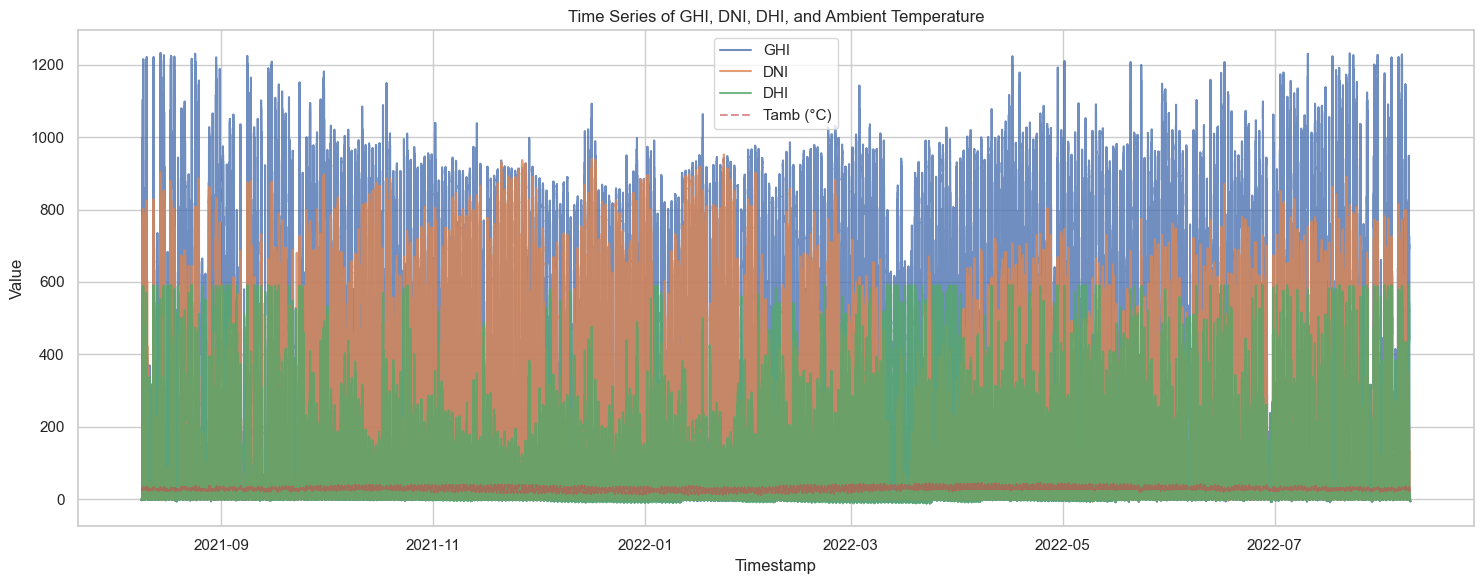

In [10]:
# Ensure Timestamp is sorted
df.sort_values("Timestamp", inplace=True)

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))

# Plot GHI, DNI, DHI, Tamb over time
plt.plot(df["Timestamp"], df["GHI"], label="GHI", alpha=0.8)
plt.plot(df["Timestamp"], df["DNI"], label="DNI", alpha=0.8)
plt.plot(df["Timestamp"], df["DHI"], label="DHI", alpha=0.8)
plt.plot(df["Timestamp"], df["Tamb"], label="Tamb (°C)", alpha=0.6, linestyle="--")

plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("Time Series of GHI, DNI, DHI, and Ambient Temperature")
plt.legend()
plt.tight_layout()
plt.show()

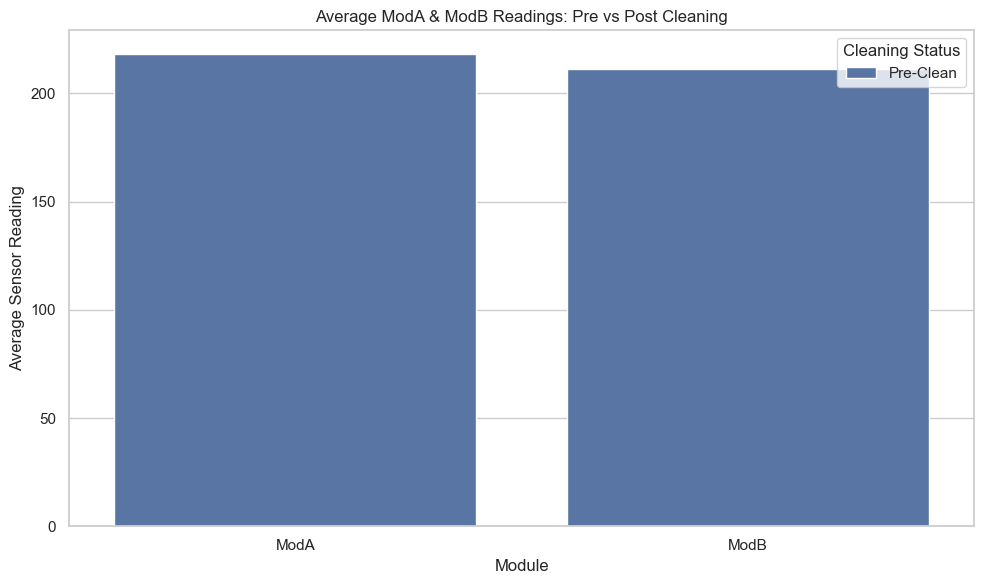

In [11]:
cleaning_avg = df.groupby("Cleaning")[["ModA", "ModB"]].mean().reset_index()
cleaning_avg["Cleaning"] = cleaning_avg["Cleaning"].map({0: "Pre-Clean", 1: "Post-Clean"})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=cleaning_avg.melt(id_vars="Cleaning"), x="variable", y="value", hue="Cleaning")

plt.title("Average ModA & ModB Readings: Pre vs Post Cleaning")
plt.ylabel("Average Sensor Reading")
plt.xlabel("Module")
plt.legend(title="Cleaning Status")
plt.tight_layout()
plt.show()

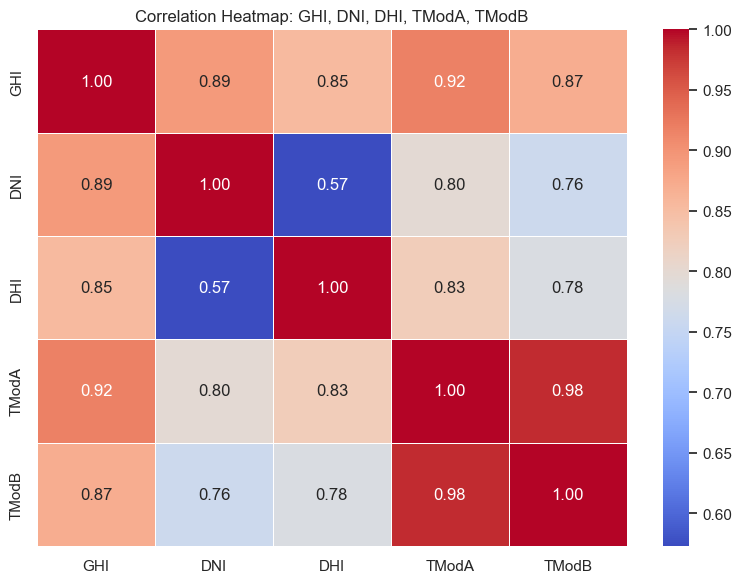

In [12]:
corr_cols = ["GHI", "DNI", "DHI", "TModA", "TModB"]
corr_matrix = df[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: GHI, DNI, DHI, TModA, TModB")
plt.tight_layout()
plt.show()

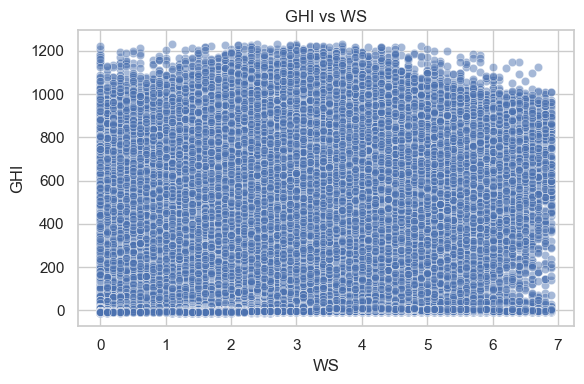

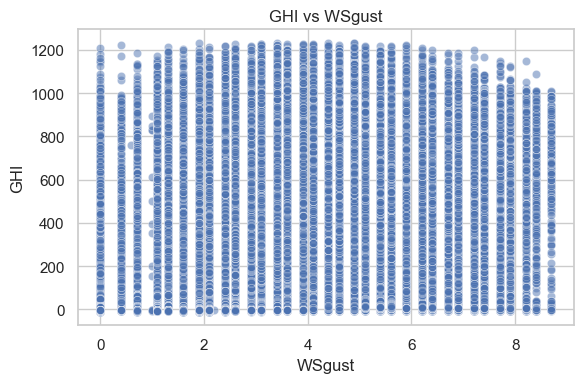

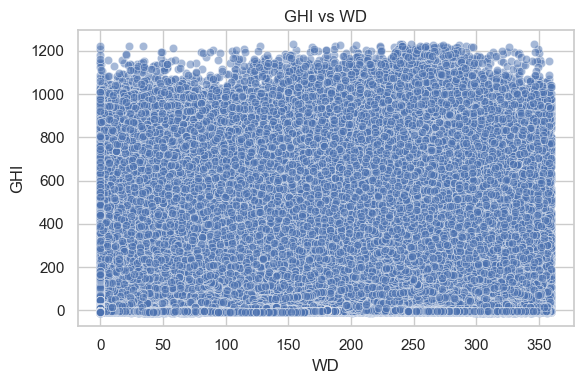

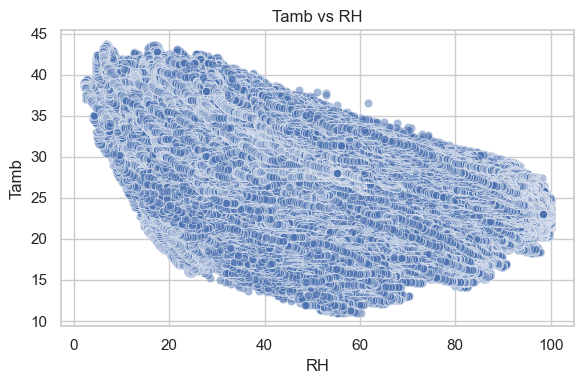

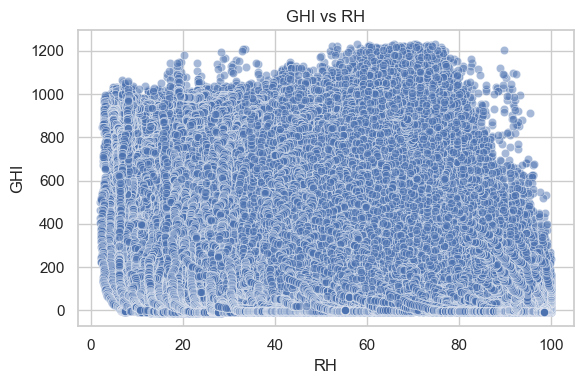

In [13]:
# Define scatter plot function
def scatter_plot(x, y):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.title(f"{y} vs {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()

# Wind parameters vs. GHI
scatter_plot("WS", "GHI")
scatter_plot("WSgust", "GHI")
scatter_plot("WD", "GHI")

# Relative Humidity vs. Tamb and GHI
scatter_plot("RH", "Tamb")
scatter_plot("RH", "GHI")

C:\Users\Time\AppData\Local\Temp\ipykernel_3516\1142280665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = get_cmap("viridis")(np.linspace(0, 1, len(ws_bins)))


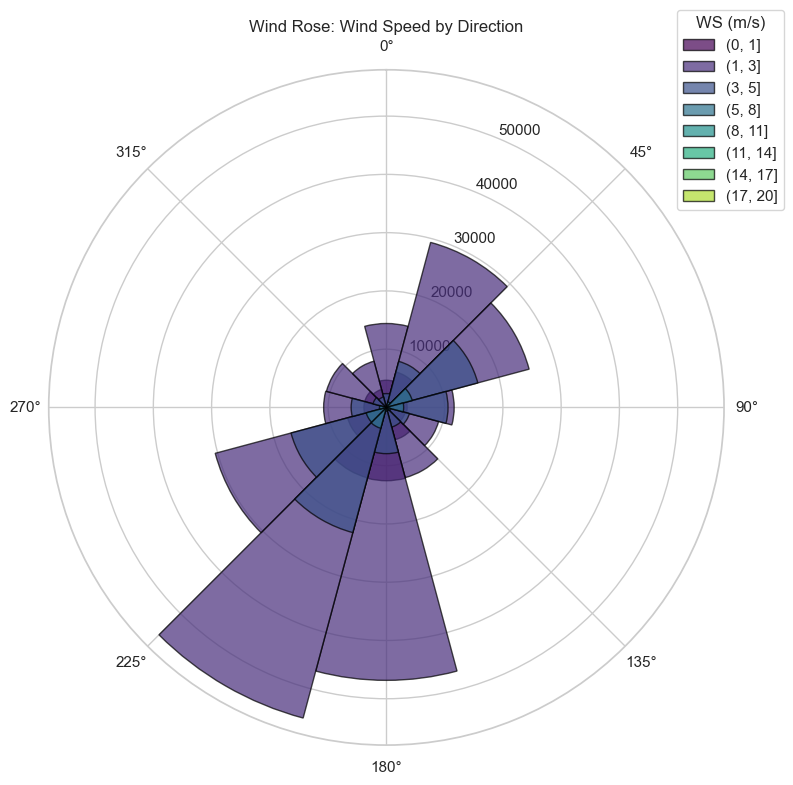

In [14]:
# Remove rows with missing WS or WD
wind_data = df[["WS", "WD"]].dropna()

# Convert WD to radians
angles = np.deg2rad(wind_data["WD"])

# Set up bins for wind speed
ws_bins = [0, 1, 3, 5, 8, 11, 14, 17, 20]
wind_data["WS_bin"] = pd.cut(wind_data["WS"], bins=ws_bins)

# Create wind rose
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

# Plot each wind speed bin
colors = get_cmap("viridis")(np.linspace(0, 1, len(ws_bins)))
for i, bin_range in enumerate(wind_data["WS_bin"].cat.categories):
    subset = wind_data[wind_data["WS_bin"] == bin_range]
    counts, _ = np.histogram(subset["WD"], bins=np.arange(0, 361, 30))
    angles = np.deg2rad(np.arange(0, 360, 30))
    ax.bar(angles, counts, width=np.deg2rad(30), bottom=0.0, color=colors[i], alpha=0.7, edgecolor='black', label=str(bin_range))

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.legend(title="WS (m/s)", bbox_to_anchor=(1.1, 1.1))
plt.title("Wind Rose: Wind Speed by Direction")
plt.tight_layout()
plt.show()

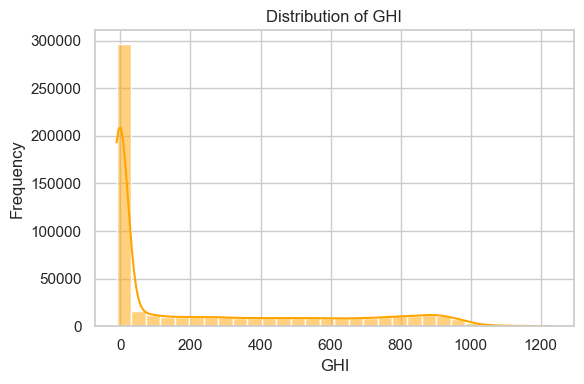

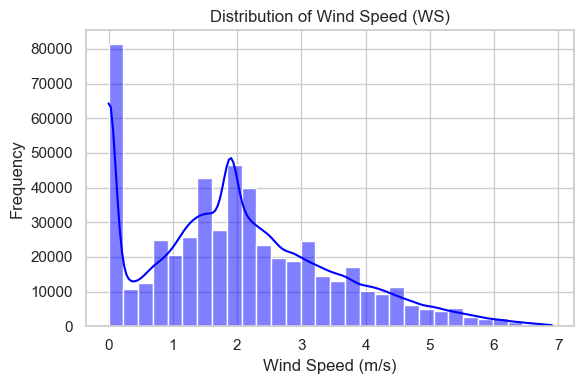

In [15]:
# Histogram for GHI
plt.figure(figsize=(6, 4))
sns.histplot(df["GHI"].dropna(), bins=30, kde=True, color='orange')
plt.title("Distribution of GHI")
plt.xlabel("GHI")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Histogram for WS
plt.figure(figsize=(6, 4))
sns.histplot(df["WS"].dropna(), bins=30, kde=True, color='blue')
plt.title("Distribution of Wind Speed (WS)")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

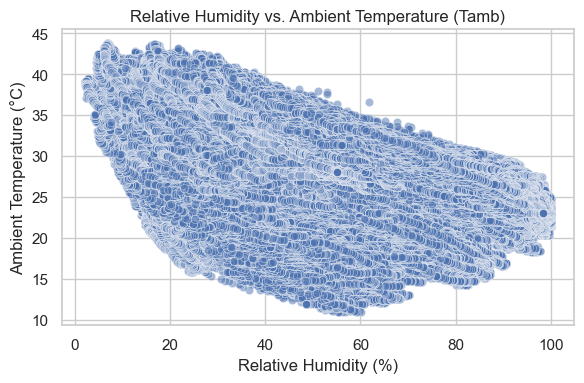

In [16]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='RH', y='Tamb', data=df, alpha=0.5)
plt.title("Relative Humidity vs. Ambient Temperature (Tamb)")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Ambient Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

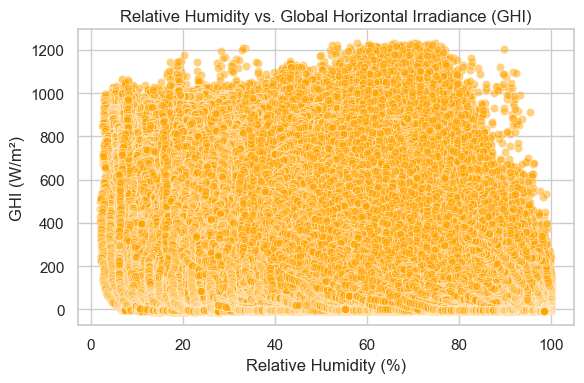

In [17]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='RH', y='GHI', data=df, alpha=0.5, color='orange')
plt.title("Relative Humidity vs. Global Horizontal Irradiance (GHI)")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("GHI (W/m²)")
plt.grid(True)
plt.tight_layout()
plt.show()

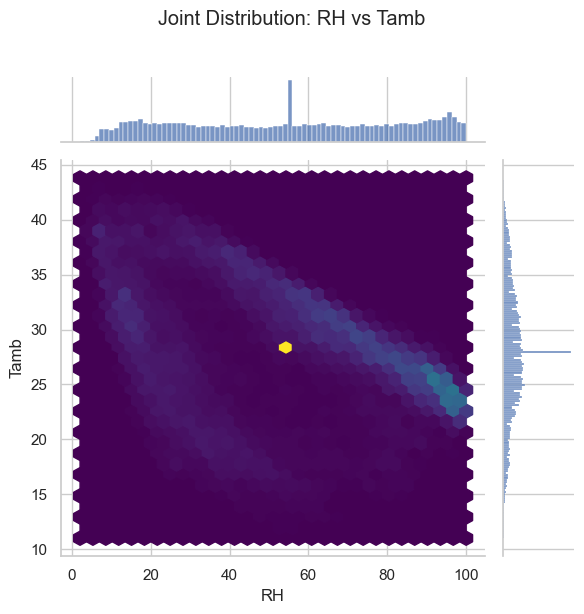

In [18]:
sns.jointplot(data=df, x="RH", y="Tamb", kind="hex", gridsize=30, cmap="viridis")
plt.suptitle("Joint Distribution: RH vs Tamb", y=1.02)
plt.tight_layout()
plt.show()

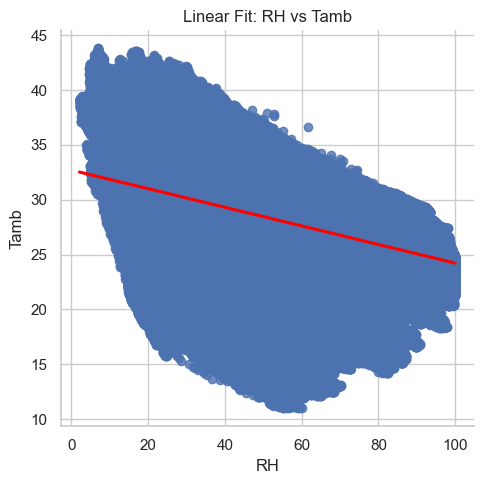

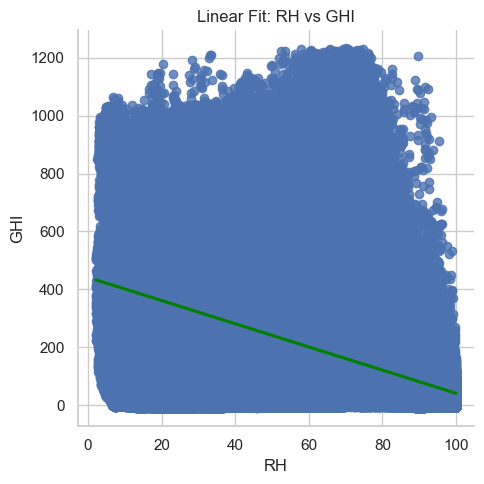

In [19]:
sns.lmplot(x="RH", y="Tamb", data=df, line_kws={"color": "red"})
plt.title("Linear Fit: RH vs Tamb")
plt.tight_layout()
plt.show()

sns.lmplot(x="RH", y="GHI", data=df, line_kws={"color": "green"})
plt.title("Linear Fit: RH vs GHI")
plt.tight_layout()
plt.show()

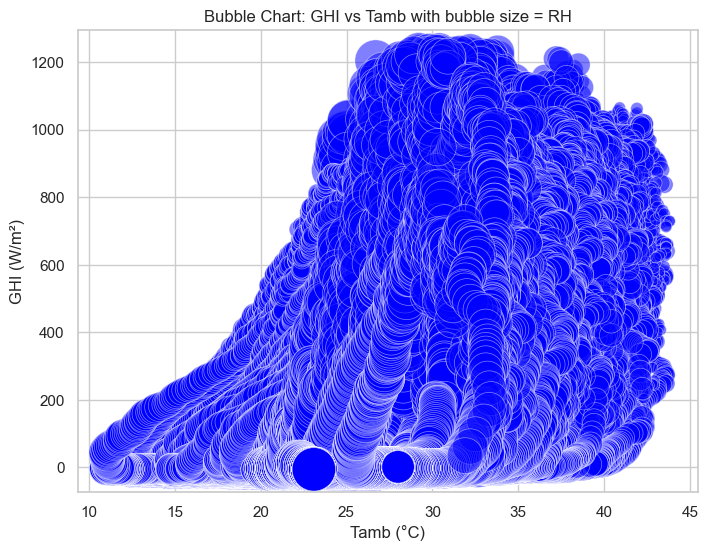

In [20]:
plt.figure(figsize=(8,6))

# Bubble size scaled for better visualization
sizes = df['RH'] * 10  # multiply by 10 or any scaling factor

plt.scatter(df['Tamb'], df['GHI'], s=sizes, alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

plt.title('Bubble Chart: GHI vs Tamb with bubble size = RH')
plt.xlabel('Tamb (°C)')
plt.ylabel('GHI (W/m²)')
plt.grid(True)
plt.show()